# Pattern Comparison of Frequency of DEG in ASD patients with or without Epilepsy

<br/><br/>
ASD는 그 자체로 상당히 힘든 질병이지만, ASD 환자들 중 상당 수가 Epilepsy도 동시에 관찰되고 있다. Epilepsy는 발작(Seizure)을 동반하여 발생하며 Epilepsy 환자 중 상당수가 갑작스럽게 죽음을 맞이하는 경우를 볼 수 있다.[data S1] 따라서 단순히 ASD만 가지고 있는 집단과 ASD와 Epilepsy를 모두 가지고 있는 집단들 사이에는 유전적 발현패턴에 차이가 있음을 유추해 볼 수 있다. 따라서 여기에서는 __data S4__ 의 __Individual Specific DEG__를 통해 환자 집단 사이에서 어떤 빈도로 DEG의 발현이 일어나는지 그 패턴을 보고자 했다. 

주어진 Individual Specific DEG의 특징은 각 gene에 대한 정량적인 정보 없이 DEG의 발현 방향이 control group과 비교했을 때 더 많이 발현되었는지 적게 발현되었는지 여부만을 보여주고 있다. 따라서 이러한 정량적 데이터의 부족을 극복하기 위해서 'ASD_patients_with_DE_signal' column의 환자를 ASD만 가진 환자와 ASD와 Epilepsy를 가진 환자로 분류하고 유전자별 DEG의 발현 횟수를 확인하였다. 발현 빈도는 각 환자의 case(ASD_only, ASD_Epilepsy)의 수로 나눠주어 구하였다. 그리고 upregulated case와 downregulated case를 구분하기 위해서 downregulated case의 경우 (-)부호를 붙여주었다. 


New names:
* `` -> ...9
* `` -> ...10
* `` -> ...11
* `` -> ...12

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



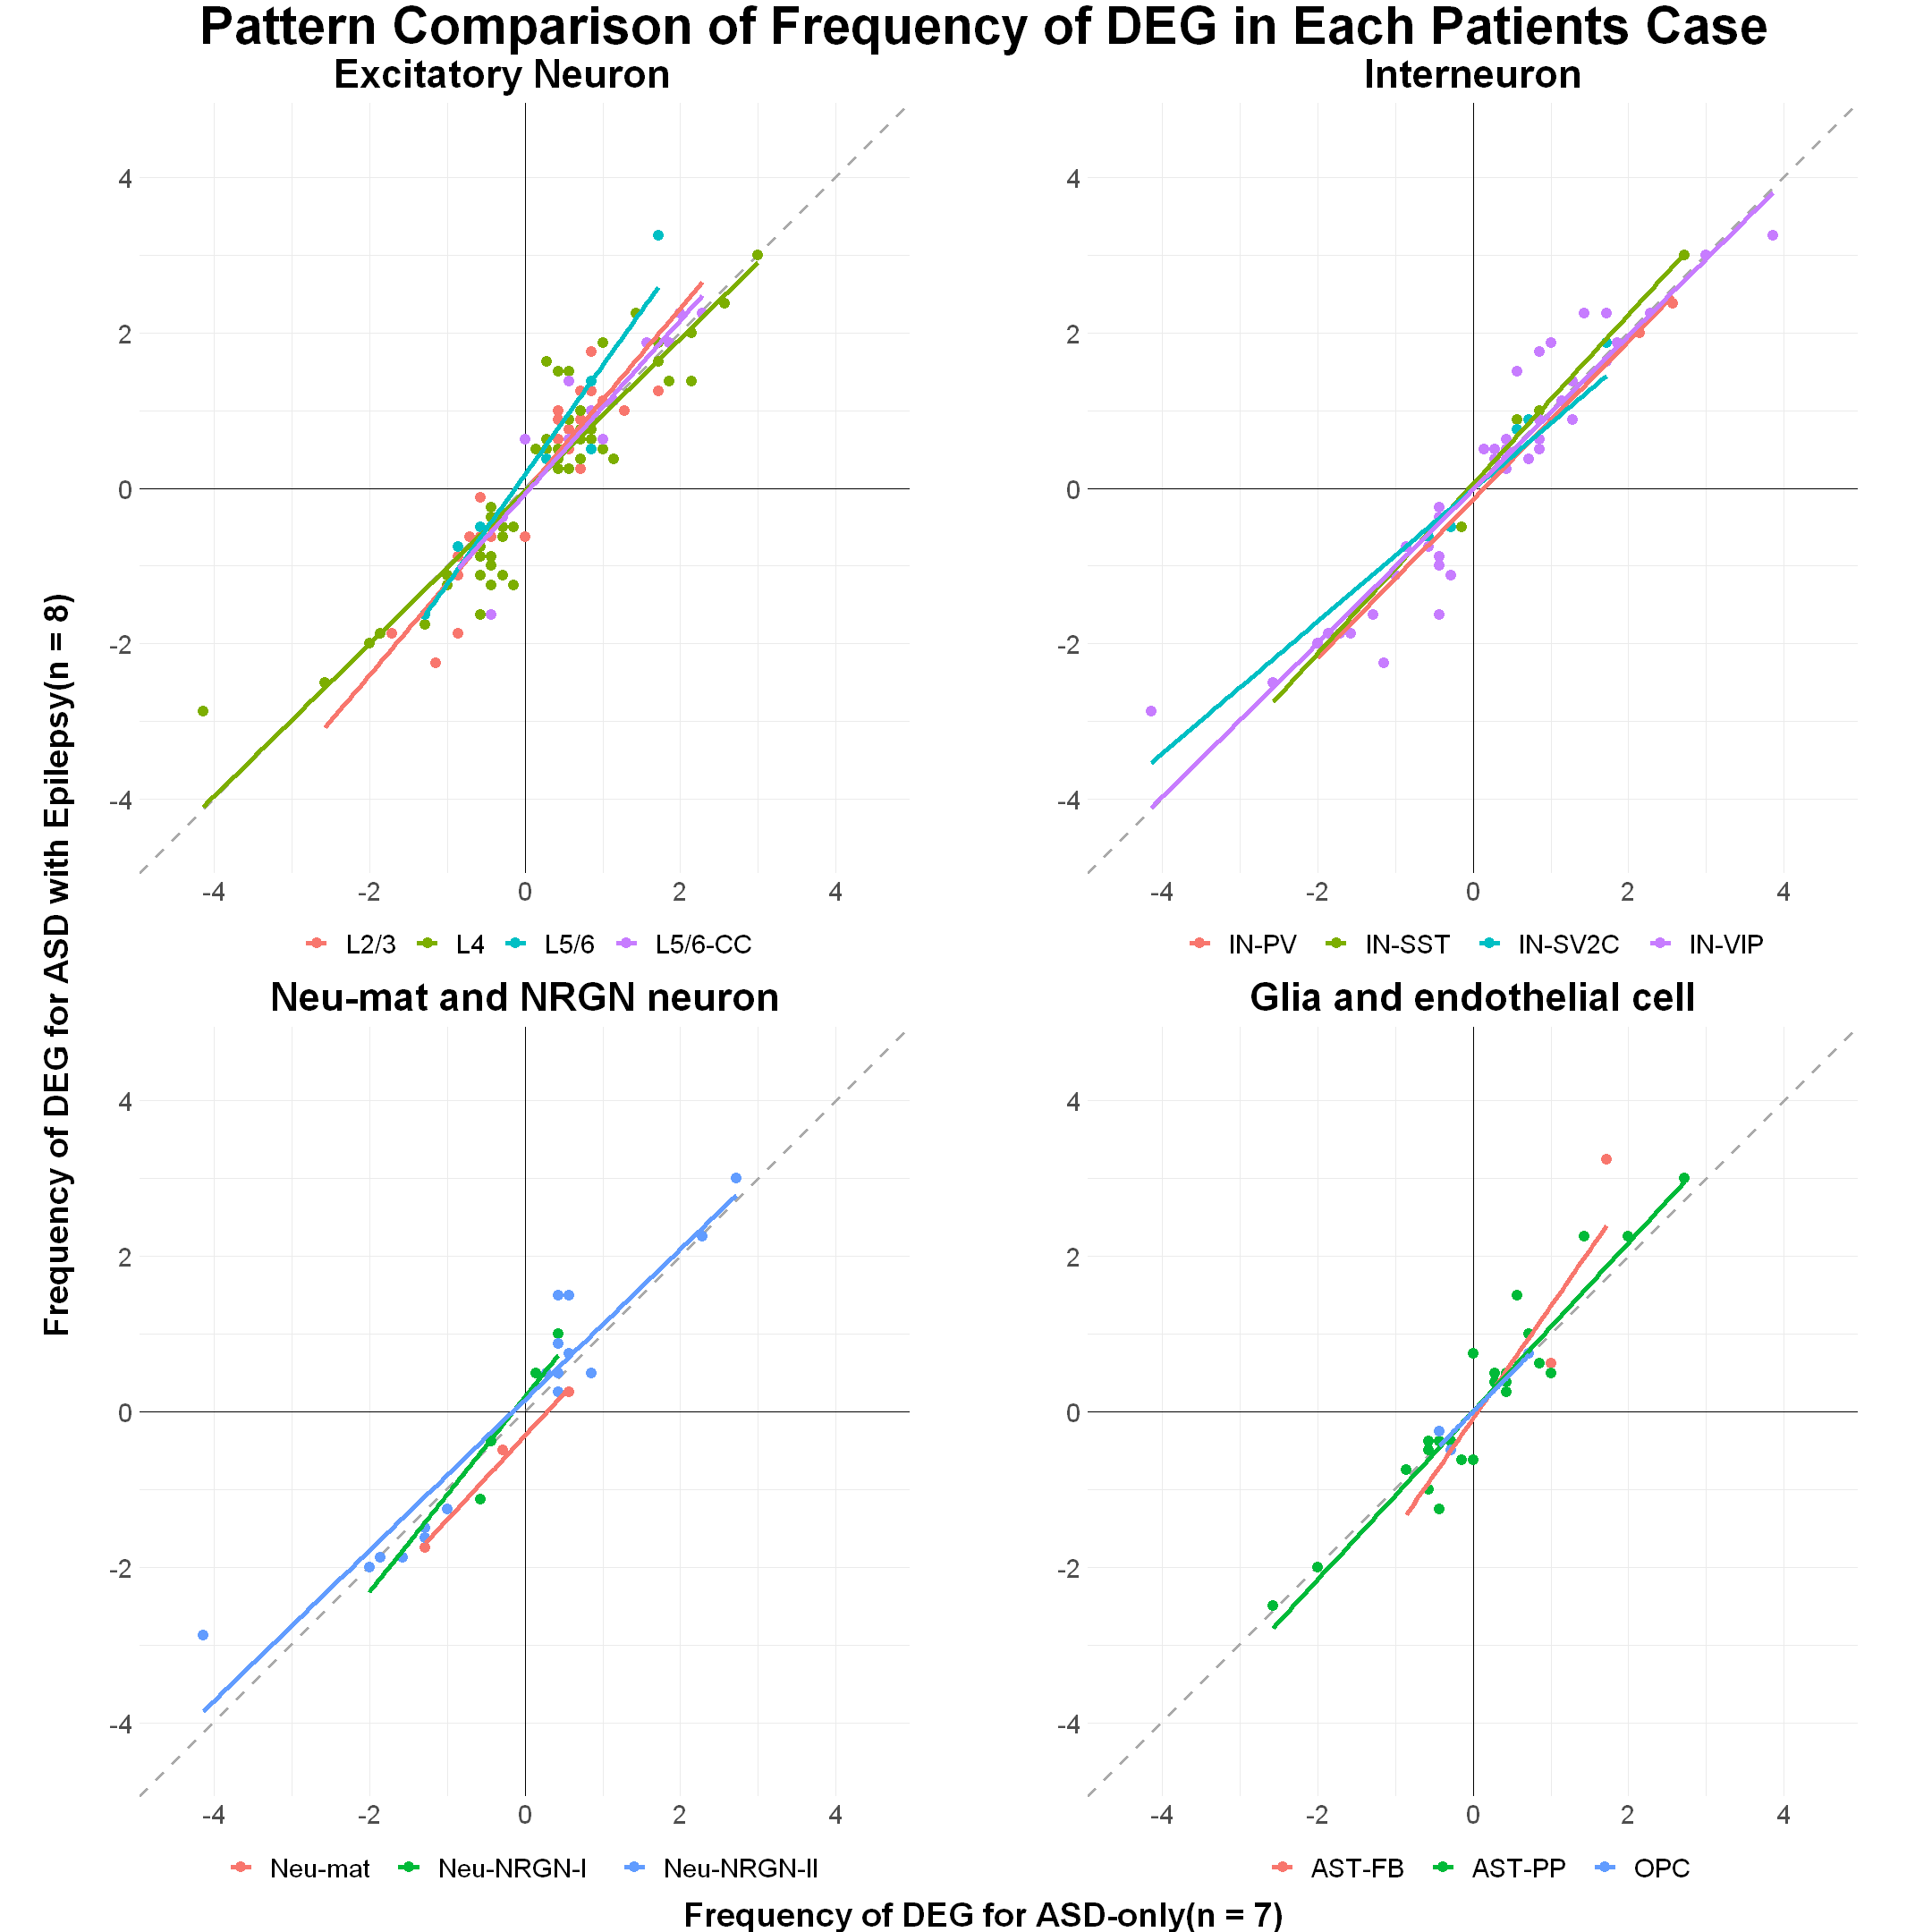

In [121]:
options(repr.plot.width=18, repr.plot.height=18)
library(tidyverse)
library(readxl)
library(cowplot)
library(ggpubr)

ASD_DEG <- read_excel("C:/Users/withj/Rproject/aav8130_Data-S4.xlsx", sheet = 1)
ASD_sample <- read_excel("C:/Users/withj/Rproject/aav8130_Data-S1.xlsx", sheet = 1)
Ind_DEG <- read_excel("C:/Users/withj/Rproject/aav8130_Data-S4.xlsx", sheet = 4)

#ASD+Epilepsy Patient ID
a_id <- ASD_sample %>% filter(grepl("Epilepsy", ASD_sample$Other_diagnoses)) %>% .$Patient_ID

# code to get the number of patients for each patients case  
a <- Ind_DEG %>% 
  separate_rows(ASD_patients_with_DE_signal) %>%
  mutate(patient_case = ifelse(ASD_patients_with_DE_signal %in% a_id  ,
                               "ASD_Epilepsy", "ASD_only")) %>%
  .$ASD_patients_with_DE_signal %>% unique() 

#wrangling

Ind_DEG1 <-Ind_DEG %>% 
  separate_rows(ASD_patients_with_DE_signal) %>%
  mutate(patient_case = ifelse(ASD_patients_with_DE_signal %in% a_id  ,
                               "ASD_Epilepsy", "ASD_only")) %>%
  group_by(Gene_name, patient_case) %>%
  count(`Direction_of_change_(ASD/Control)`) %>%
  merge(x =., y = select(ASD_DEG, Cell_type, Gene_name), by = "Gene_name") %>%
  mutate(n = ifelse(patient_case == "ASD_Epilepsy", n/8, n/7))%>%
  mutate(average_DEG = ifelse(`Direction_of_change_(ASD/Control)` == "DOWN", -n, n)) %>%
  mutate(col_id = paste(Cell_type, Gene_name, `Direction_of_change_(ASD/Control)`, sep="."))


Ind_DEG2 <- Ind_DEG1 %>% 
  select(col_id, patient_case, average_DEG) %>%
  spread(patient_case, average_DEG) %>%
  mutate(ASD_Epilepsy = replace_na(ASD_Epilepsy, 0)) %>%
  mutate(ASD_only = replace_na(ASD_only, 0)) %>%
  merge(x = ., y = Ind_DEG1 %>% select(col_id, Cell_type), 
        by = "col_id" ) 

#plot code
 ggarrange(
Ind_DEG2 %>%
  filter(Cell_type %in% c("L2/3", "L4", "L5/6", "L5/6-CC")) %>%
  ggplot(aes(ASD_only, ASD_Epilepsy, color = Cell_type)) +
  geom_hline(yintercept = 0)+
  geom_vline(xintercept = 0)+
  geom_abline(color = "dark grey", lwd = 1, linetype = "dashed") +
  geom_point(size = 3) +
  geom_smooth(method = "lm", se = FALSE, lwd = 1.5)+
  coord_fixed(ratio = 1) +
  labs(title = "Excitatory Neuron") +
  theme_minimal() +
  scale_x_continuous(limit=c(-4.5,4.5), breaks = c(-4,-2,0,2,4))+
  scale_y_continuous(limit=c(-4.5,4.5), breaks = c(-4,-2,0,2,4))+
  theme(legend.title = element_blank(),
        plot.title = element_text(hjust=0.45, face = "bold"),
        text = element_text(size = 22),
        axis.title = element_blank(),
        legend.position = "bottom"), 
    
Ind_DEG2 %>%
  filter(Cell_type %in% c("IN-PV","IN-SST","IN-SV2C","IN-VIP")) %>%
  ggplot(aes(ASD_only, ASD_Epilepsy, color = Cell_type)) +
  geom_hline(yintercept = 0)+
  geom_vline(xintercept = 0)+
  geom_abline(color = "dark grey", lwd = 1, linetype = "dashed") +
  geom_point(size = 3) +
  geom_smooth(method = "lm", se = FALSE, lwd = 1.5)+
  coord_fixed(ratio = 1) +
  labs(title = "Interneuron") +
  theme_minimal() +
  scale_x_continuous(limit=c(-4.5,4.5), breaks = c(-4,-2,0,2,4))+
  scale_y_continuous(limit=c(-4.5,4.5), breaks = c(-4,-2,0,2,4))+
  theme(legend.title = element_blank(),
        plot.title = element_text(hjust=0.5, face = "bold"),
        text = element_text(size = 22),
        axis.title = element_blank(),
       legend.position = "bottom"),
    
Ind_DEG2 %>%
  filter(Cell_type %in% c("Neu-mat", "Neu-NRGN-I","Neu-NRGN-II")) %>%
  ggplot(aes(ASD_only, ASD_Epilepsy,, color = Cell_type)) +
  geom_hline(yintercept = 0)+
  geom_vline(xintercept = 0)+
  geom_abline(color = "dark grey", lwd = 1, linetype = "dashed") +
  geom_point(size = 3) +
  geom_smooth(method = "lm", se = FALSE, lwd = 1.5)+
  coord_fixed(ratio = 1) +
  labs(title = "Neu-mat and NRGN neuron") +
  theme_minimal() +
  scale_x_continuous(limit=c(-4.5,4.5), breaks = c(-4,-2,0,2,4))+
  scale_y_continuous(limit=c(-4.5,4.5), breaks = c(-4,-2,0,2,4))+
  theme(legend.title = element_blank(),
        plot.title = element_text(hjust=0.5, face = "bold"), 
        text = element_text(size = 22),
        axis.title = element_blank(),
       legend.position = "bottom"), 
    
Ind_DEG2 %>%
  filter(Cell_type %in% c("AST-FB","AST-PP", "OPC")) %>%
  ggplot(aes(ASD_only, ASD_Epilepsy, color = Cell_type)) +
  geom_hline(yintercept = 0)+
  geom_vline(xintercept = 0)+
  geom_abline(color = "dark grey", lwd = 1, linetype = "dashed") +
  geom_point(size = 3) +
  geom_smooth(method = "lm", se = FALSE, lwd = 1.5)+
  coord_fixed(ratio = 1) +
  labs(title = "Glia and endothelial cell") +
  theme_minimal() +
  scale_x_continuous(limit=c(-4.5,4.5), breaks = c(-4,-2,0,2,4))+
  scale_y_continuous(limit=c(-4.5,4.5), breaks = c(-4,-2,0,2,4))+
  theme(legend.title = element_blank(),
        plot.title = element_text(hjust=0.5, face = "bold"),
        text = element_text(size = 22),
        axis.title = element_blank(),
       legend.position = "bottom"),
ncol = 2, nrow = 2) %>%
annotate_figure(top = text_grob("Pattern Comparison of Frequency of DEG in Each Patients Case", 
                                face = "bold", size = 35),
                bottom = text_grob("Frequency of DEG for ASD-only(n = 7)", 
                                   face = "bold", size = 22),
                left = text_grob("Frequency of DEG for ASD with Epilepsy(n = 8)", 
                                 face = "bold", size = 22, rot = 90, vjust = 2))


__Figure__ 각 점은 DEG를 의미한다. 좌표평면의 제 1사분면은 모두 upregulated 된 경우, 제 3사분면은 모두 downregulated 된 경우를 의미하며, 제 2사분면과 제 4사분면은 두 case에서 상반된 dysregulation 방향을 보이는 경우를 의미함. 점선을 기준으로 기울기가 커지면 Epilepsy를 가진 ASD 환자 집단 내에서 DEG 발현 빈도가 많다는 의미이고 기울기가 작으면 있으면 그 반대를 의미함. 

위 그림을 통해 알 수 있는 점은 전체적으로 놓고 봤을 때에는 동일한 DEG에 대해서 발현 빈도(각 집단 내의 DEG 발견 횟수/각 집단의 환자 수)가 ASD with Epilepsy(AE)가 ASD-only(Ao)보다 상대적으로 높다고 볼 수 있다. 이를 더 과발현되었다고 해석할 수는 없지만 동일한 DEG를 가지는 횟수가 더 많은 경향을 보인다고 해석할 수 있고 이는 좀 ASD에 비해서 좀 더 공통적으로 공유하는 DEG가 많은 경향을 보인다고 생각할 수도 있다. 이는 어찌보면 좀 더 특이성을 가진 증상이기 때문에 당연한 결과일 수도 있다.  

각각의 Cell group별로 보면 각 group에 따라서 그리고 각 cell type 별로도 다른 양상을 보인다. 우선 Excitatory Neuron group을 보면 가장 많은 점들이 나타나있고 전체적으로